**The goals of this project are the following:**

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import glob
import time
from collections import deque
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import utils

%matplotlib inline

print('Done')

Done


## Load The Dataset

In [2]:
# read cars and notcars
car_images = glob.glob('dataset/vehicles/**/*.png')
notcar_images = glob.glob('dataset/non-vehicles/**/*.png')
print("Number of cars image =", len(car_images))
print("Number of notcars image =", len(notcar_images))

Number of cars image = 8792
Number of notcars image = 8968


## Explore the visualization of the dataset

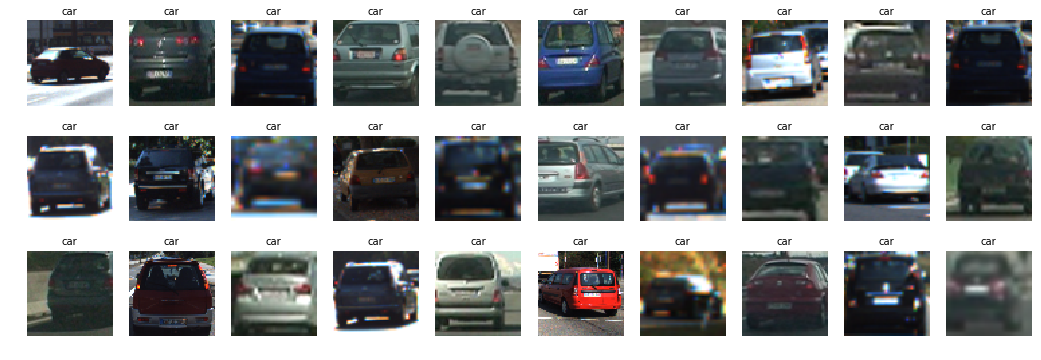

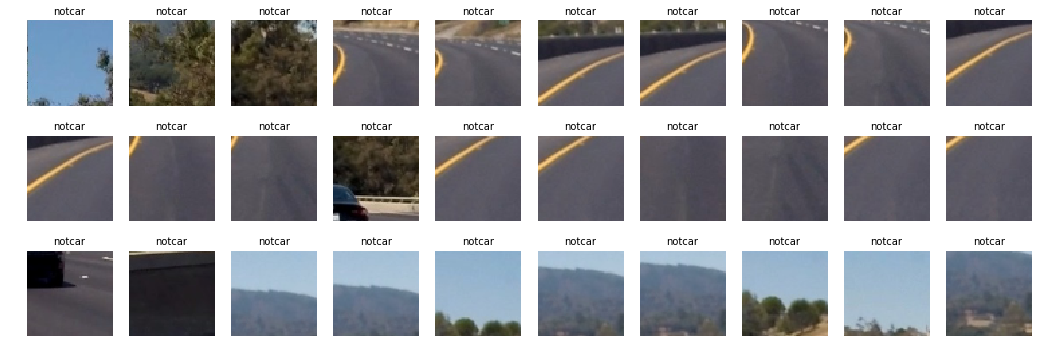

In [3]:
def show_sample_images(image_list, title):
    image_count = len(image_list)
    rows, cols = image_count//10, 10
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6))
    for idx, ax in enumerate(axes.flatten()):
        if idx < image_count:
            ax.set_title(title, fontsize=10)
            ax.imshow(mpimg.imread(image_list[idx]))
        ax.axis('off')
        
np.random.shuffle(car_images)
show_sample_images(car_images[:30], 'car')
show_sample_images(notcar_images[:30], 'notcar')

## Visualize HOG for a car image

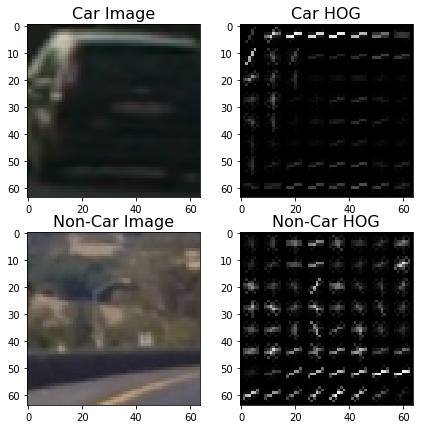

In [4]:
rand_idx = np.random.randint(0, 100)
car_img = mpimg.imread(car_images[rand_idx])
_, car_hog = utils.get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcar_images[rand_idx])
_, notcar_hog = utils.get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(notcar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

## Function to extract features from a list of images

In [5]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = utils.bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = utils.color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(utils.get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = utils.get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

print('Done')

Done


## Extract feature and split them

In [6]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


t=time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

221.23 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Train a SVM Classifier

In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

229.65 Seconds to train SVC...
Test Accuracy of SVC =  0.9859
My SVC predicts:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
0.03581 Seconds to predict 10 labels with SVC


## Function for Using Classifier to Detect Cars

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, search_all_rectangles=False):
    
    rectangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = utils.convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1    
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = utils.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = utils.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = utils.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = utils.bin_spatial(subimg, size=spatial_size)
            hist_features = utils.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_features = X_scaler.transform(test_features)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or search_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

print('Done')

Done


## Test the find_cars function

In [49]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 380
ystop = 656
scale = 1.5
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print(len(rectangles), 'rectangles found in a image')


15 rectangles found in a image


## Draw the rectangles onto an example image

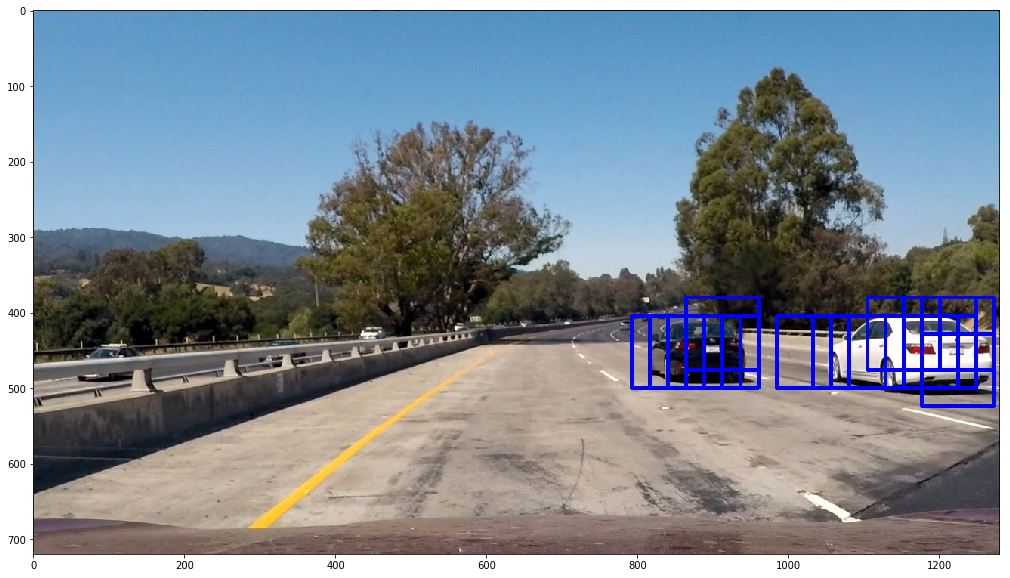

In [16]:
test_img_rects = utils.draw_boxes(test_img, rectangles)
plt.figure(figsize=(18,10))
plt.imshow(test_img_rects)

## Draw All Potential Search Areas  

Due to the size and position of cars in image is different, so find_cars will adopt different parameters which include  ystart, ystop, and scale to fit them.

### set scale to 1.0

Number of boxes:  385


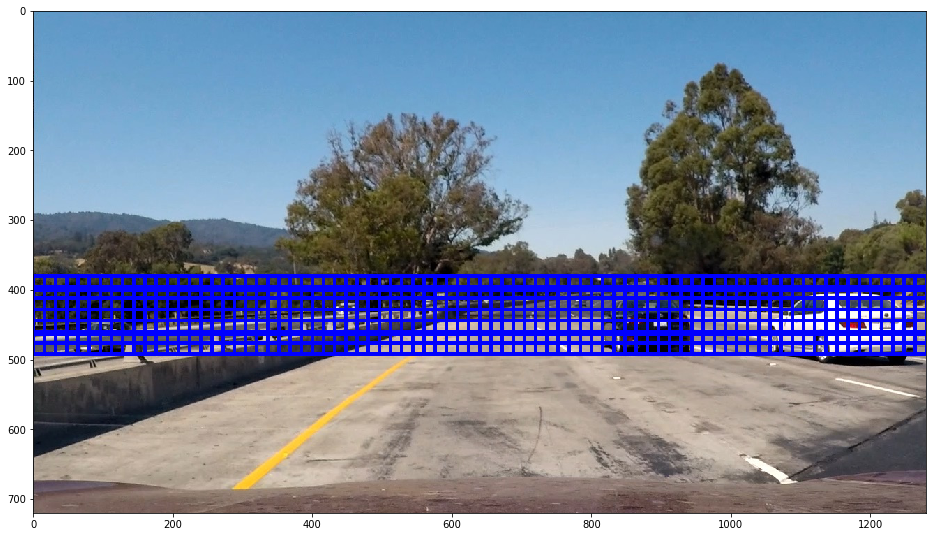

In [68]:
rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 380
ystop = 496
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))


test_img_rects = utils.draw_boxes(test_img, rectangles)
plt.figure(figsize=(16, 10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### set scale to 1.5

Number of boxes:  300


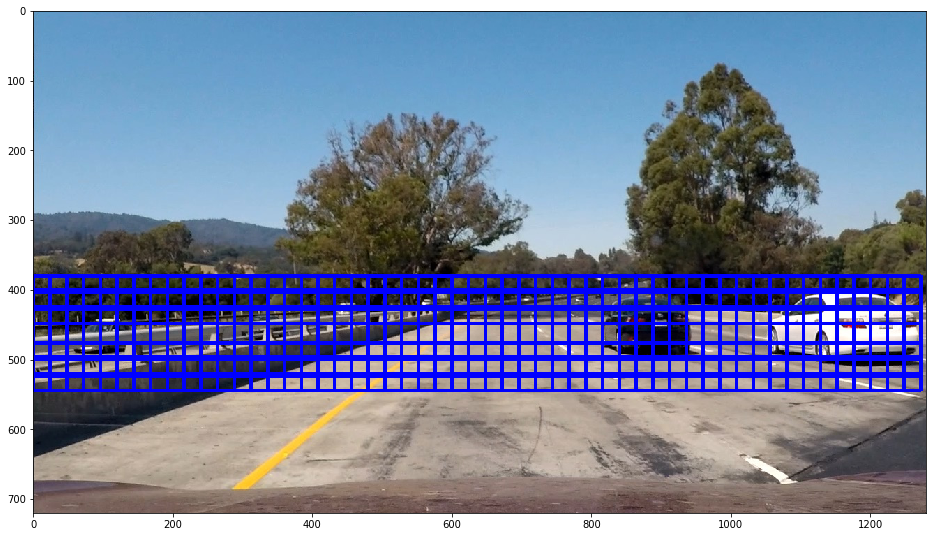

In [69]:
rectangles = []

ystart = 380
ystop = 528
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 400
ystop = 548
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

test_img_rects = utils.draw_boxes(test_img, rectangles)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### set scale to 2.0

Number of boxes:  74


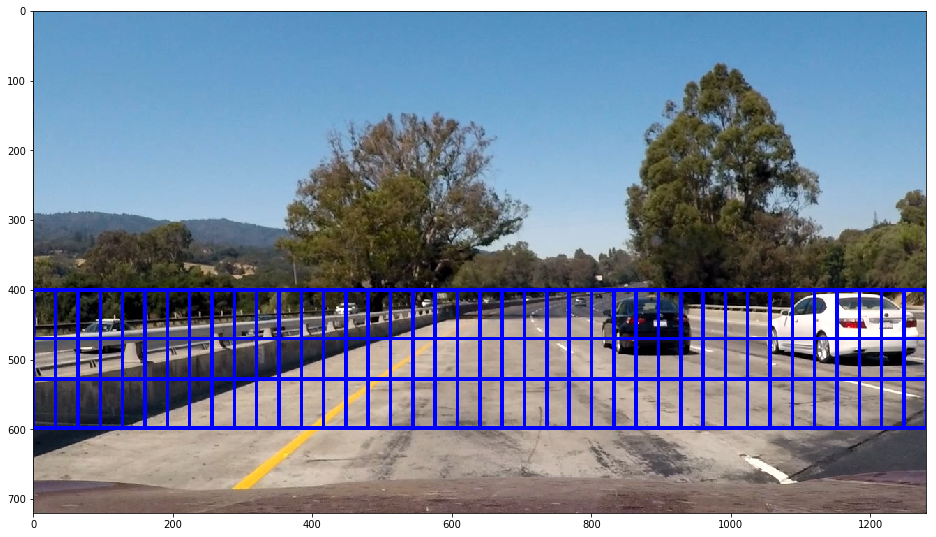

In [19]:
rectangles = []

ystart = 400
ystop = 528
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 470
ystop = 598
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

test_img_rects = utils.draw_boxes(test_img, rectangles)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### set scale to 3.0

Number of boxes:  46


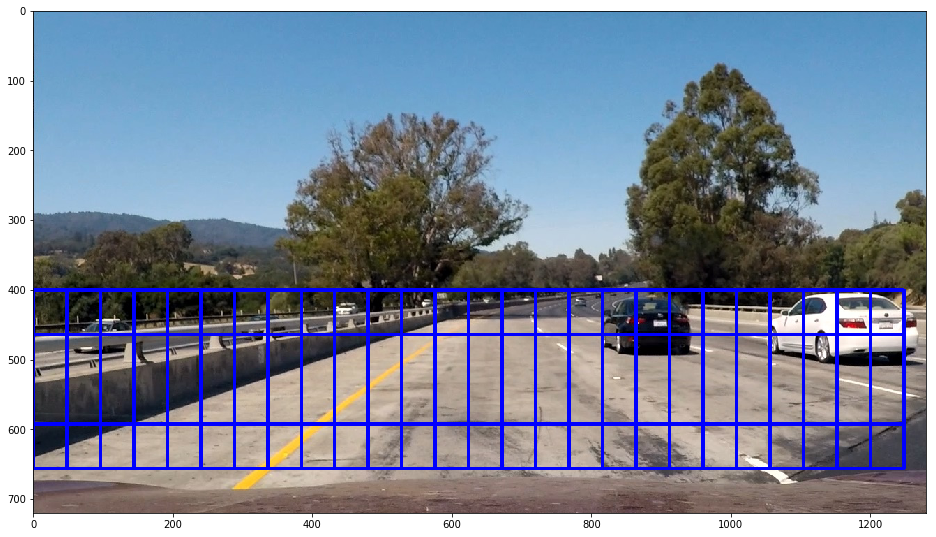

In [20]:
rectangles = []

ystart = 400
ystop = 596
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

ystart = 464
ystop = 660
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, search_all_rectangles=True))

test_img_rects = utils.draw_boxes(test_img, rectangles)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

I choosed 1.0, 1.5, 2.0 and 3.0 scale value. In order to work well, I also tweaked the ystart and ystop value.

## Combine the different sliding windows

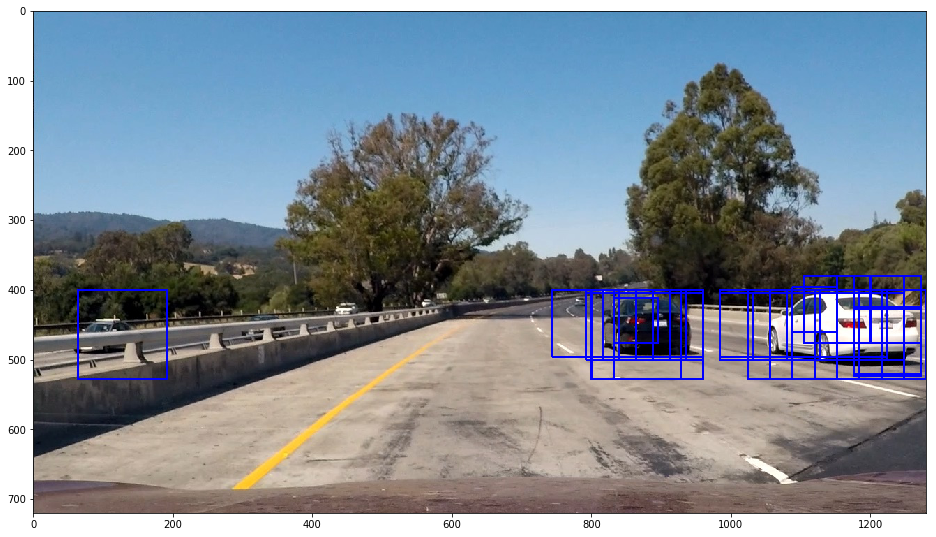

In [70]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 380
ystop = 496
scale = 1.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

ystart = 380
ystop = 528
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 400
ystop = 548
scale = 1.5
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 400
ystop = 528
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 470
ystop = 598
scale = 2.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 400
ystop = 596
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
ystart = 464
ystop = 660
scale = 3.0
rectangles.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))


test_img_rects = utils.draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(16,10))
plt.imshow(test_img_rects)

## Heatmap

To make a heat-map, you're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier.

In [71]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('Done')

Done


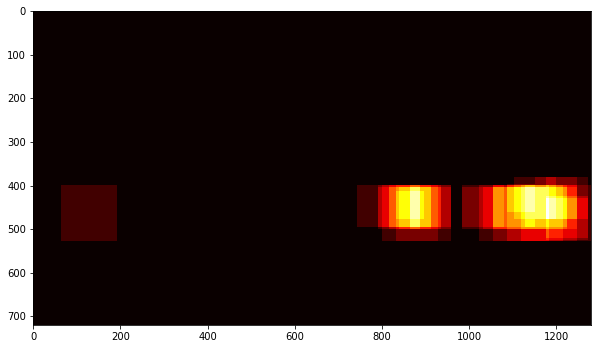

In [72]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

## Apply threshold to reject the flase positives

In [73]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('Done')

Done


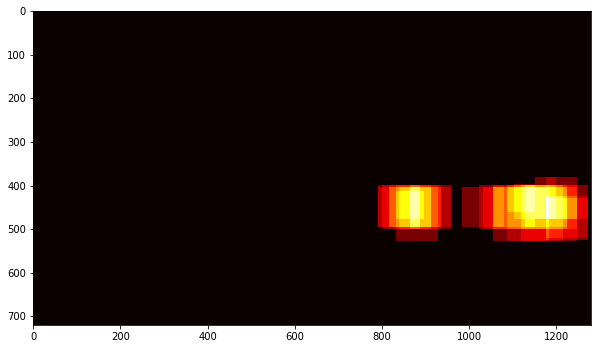

In [74]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

## Apply SciPy Label to Heatmap

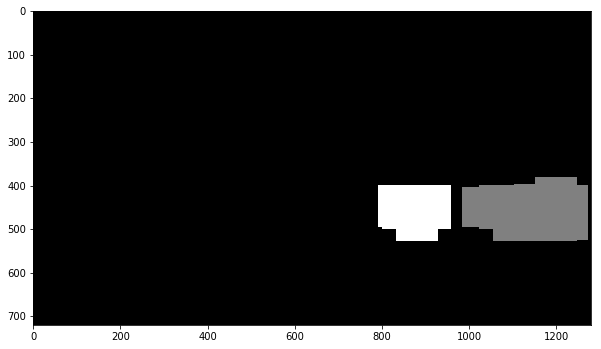

In [75]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')

## Draw Bounding Boxes for Lables

In [76]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

print('Done')

Done


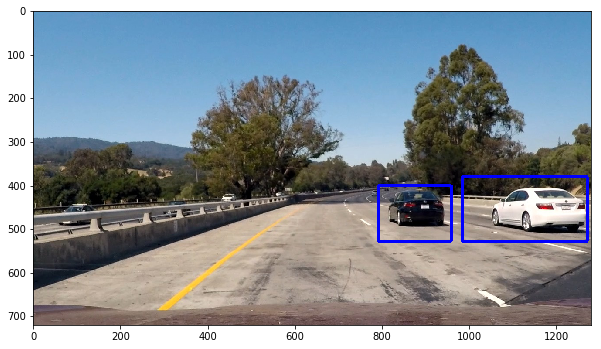

In [77]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

## Put them all together

### Pipeline to process every frame

In [79]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 380
    ystop = 496
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

    ystart = 380
    ystop = 528
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 548
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 470
    ystop = 598
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

print('Done')

Done


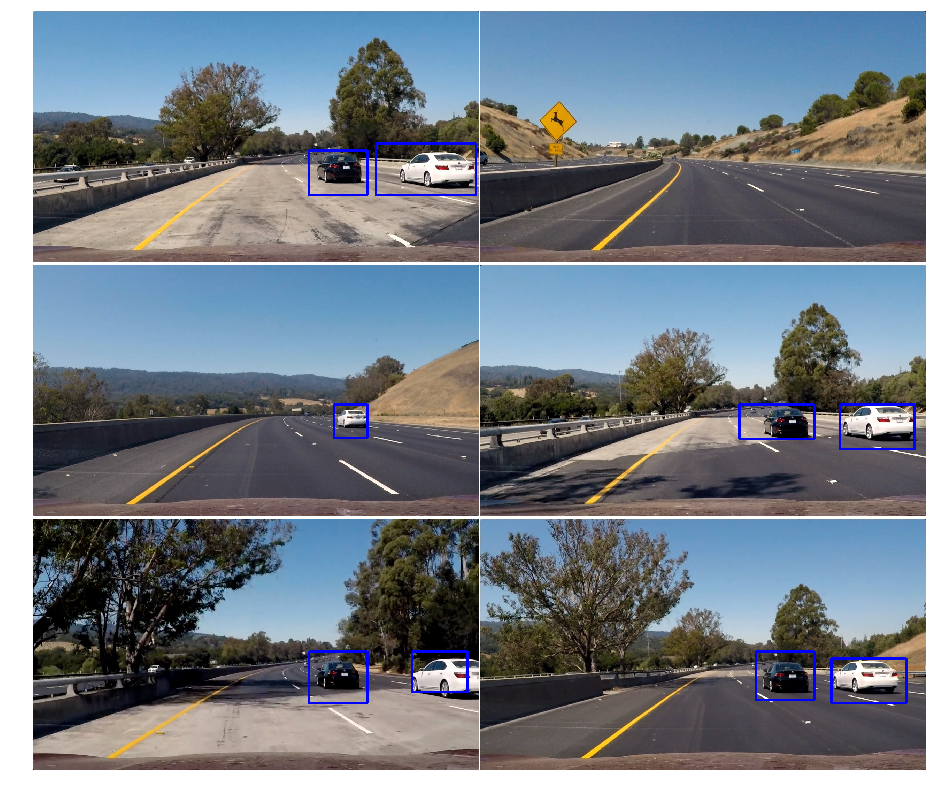

In [80]:
test_imgs = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_imgs):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Process a video with pipeline

In [81]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [04:05<00:06,  6.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min 28s, sys: 5.84 s, total: 2min 34s
Wall time: 4min 11s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

The detection rectangels seem to be jitter. So I will smooth them through the below improved method.

### Pipeline to process every n frames

In [83]:
class Vehicle_Detect(object):
    def __init__(self, n):
        # hold the detection rectangles of previous n frames
        self.prev_rects = deque(maxlen=n)
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)

In [84]:
def process_frame_from_video(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 380
    ystop = 496
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

    ystart = 380
    ystop = 528
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 548
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 470
    ystop = 598
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    
    if len(rectangles) > 0:
        veh.add_rects(rectangles)
        
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in veh.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)  
    heatmap_img = apply_threshold(heatmap_img, 1 + len(veh.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

print('Done')

Done


In [85]:
veh = Vehicle_Detect(20)
test_out_file2 = 'test_video_out2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_from_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out2.mp4
[MoviePy] Writing video test_video_out2.mp4


 97%|█████████▋| 38/39 [03:19<00:04,  4.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out2.mp4 

CPU times: user 2min 20s, sys: 6.07 s, total: 2min 26s
Wall time: 3min 23s


In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [87]:

veh = Vehicle_Detect(20)

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_frame_from_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [1:54:49<00:04,  4.86s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 18min 46s, sys: 3min 8s, total: 1h 21min 54s
Wall time: 1h 54min 53s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))